# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import os
import cv2
import tensorflow as tf
import math
from sklearn import preprocessing as skp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


%matplotlib inline


In [2]:
# Load pickled data
import pickle
import csv

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
 
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    signnames = {rows[0]:rows[1] for rows in reader}

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(np.concatenate((y_train,y_test),axis=0)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Data visualization: Plot 5 images in each class

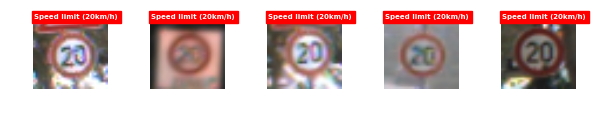

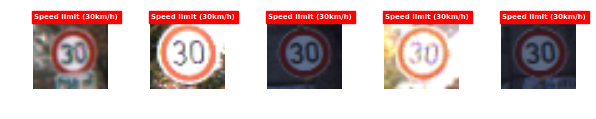

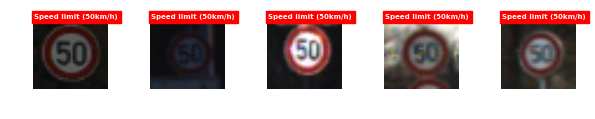

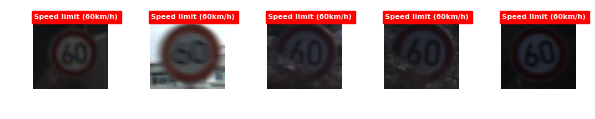

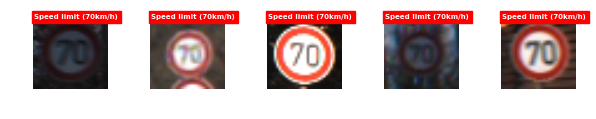

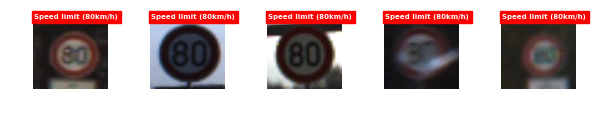

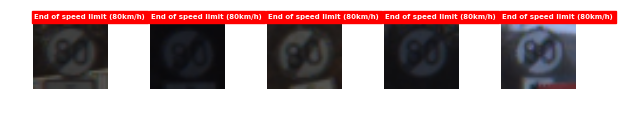

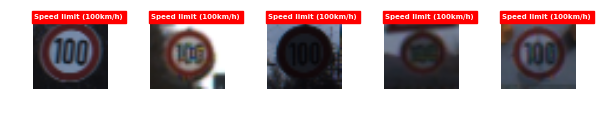

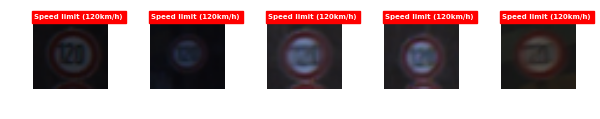

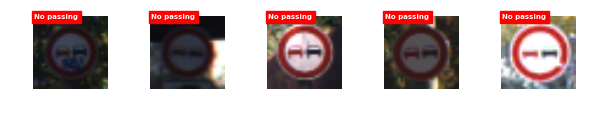

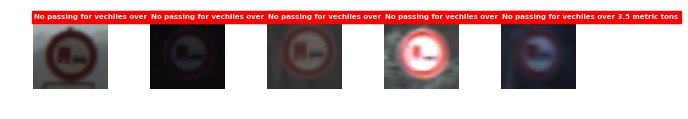

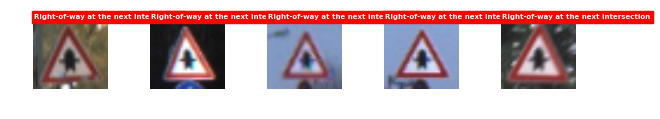

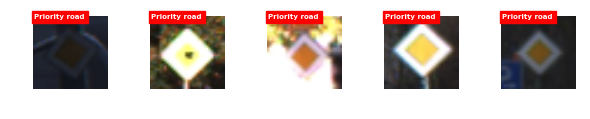

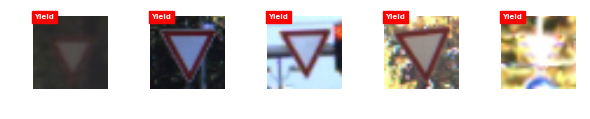

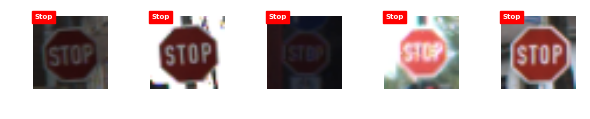

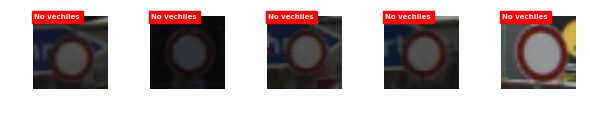

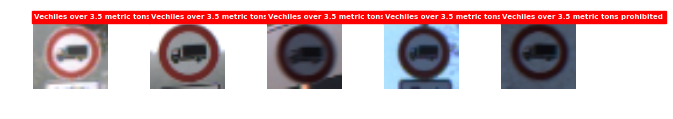

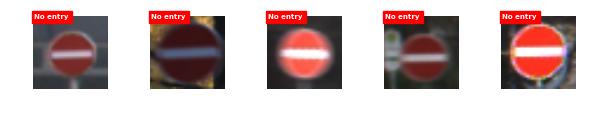

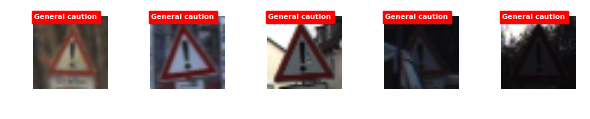

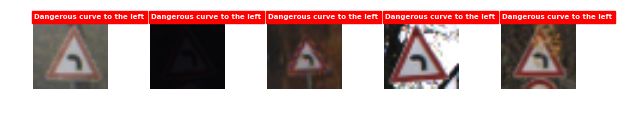

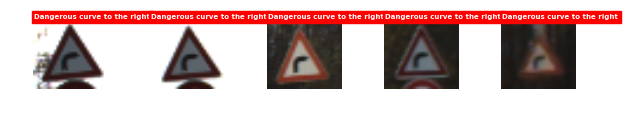

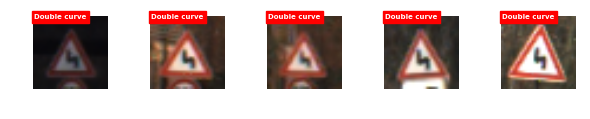

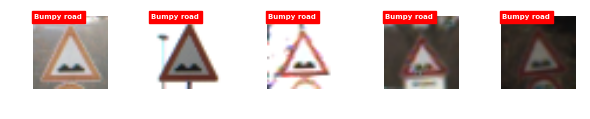

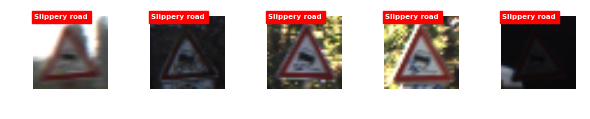

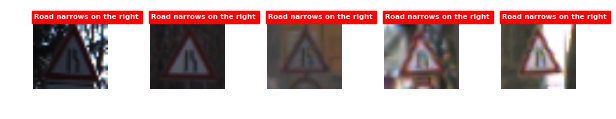

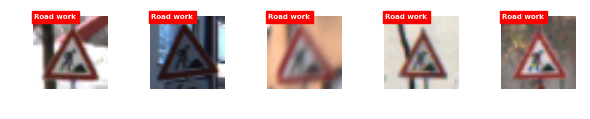

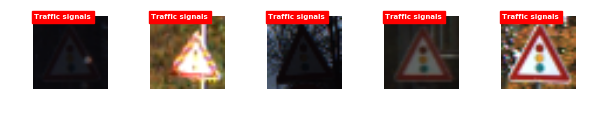

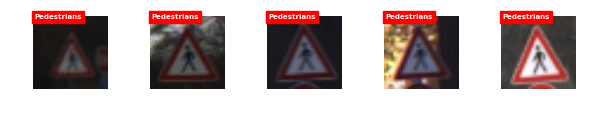

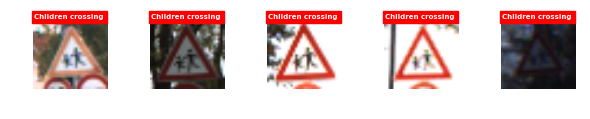

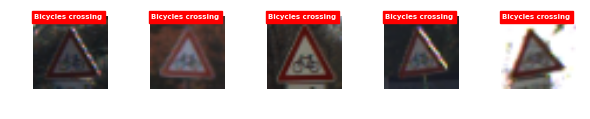

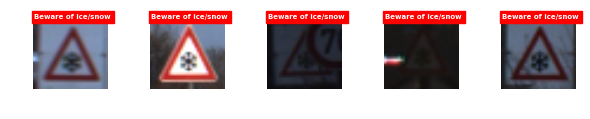

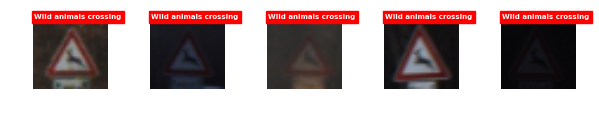

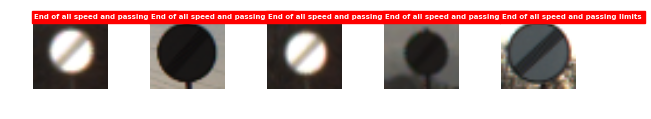

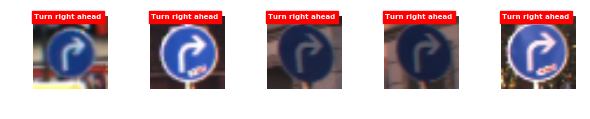

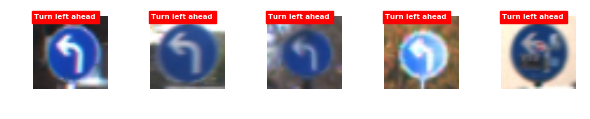

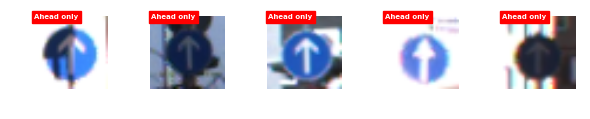

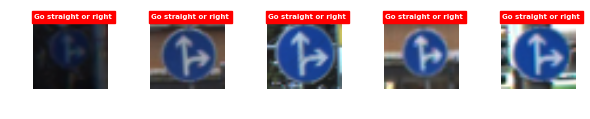

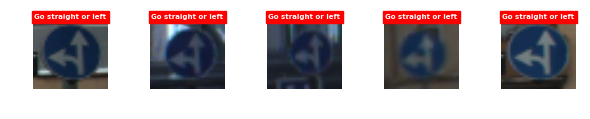

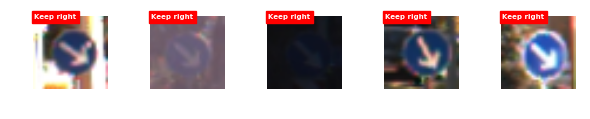

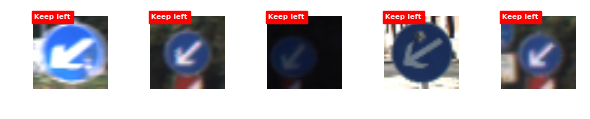

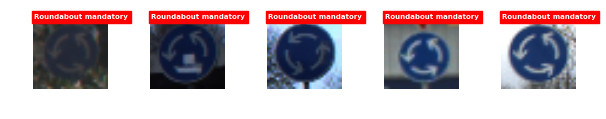

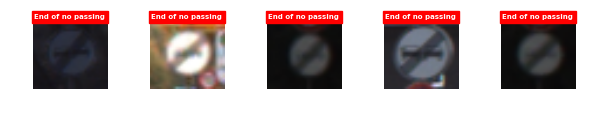

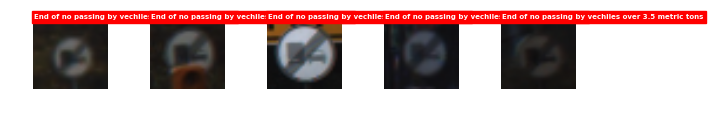

In [4]:
y = pd.DataFrame(y_train)
y.columns = ['class']
y['index'] = y.index

gb = y.groupby(['class'])
#print(gb['index'].agg([np.min,np.max]))

num_image = 5
for c in range(n_classes):
    # filter 
    yf = y[y['class']== c].sample(num_image)
    idx = (yf['index'])
    fig = plt.figure()
    for i in range(num_image):
        fig.add_subplot(1,num_image,i+1)
        plt.imshow(X_train[idx][i])
        plt.text(0,1,signnames[str(c)],color='w',backgroundcolor='r', fontsize=5, weight="bold") 
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# Number of examples from each class

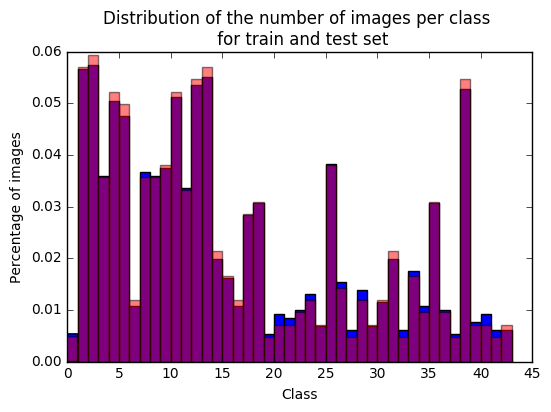

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

#print(dict(zip(unique, counts)))
plt.hist(y_train, color = 'b', label = 'train', normed = True, bins=range(n_classes+1))
plt.hist(y_test, color = 'r', alpha = 0.5, label = 'test', normed = True, bins=range(n_classes+1))
plt.title('Distribution of the number of images per class \n for train and test set')
plt.xlabel('Class')
plt.ylabel('Percentage of images')
plt.show()


* The distribution of classes is very unbalanced.
* The distribution is similar for the training and test set

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.


### 1. Data augmentation

We'll create new images to make the data set balanced. (same number of images per class)

In [7]:
# function found on Udacity forum and re-used here.
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

Example of augmented images:

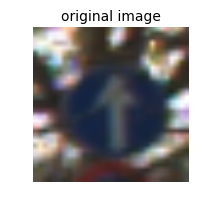

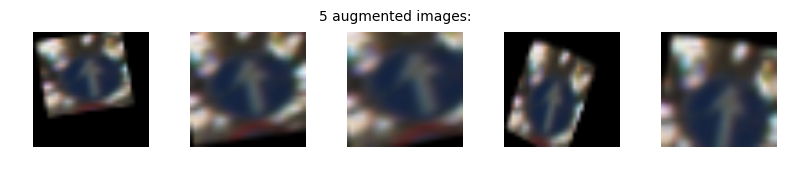

In [8]:
oi = np.random.randint(0,n_train)
orig_img = X_train[oi]

fig = plt.figure(figsize=(2,2))
fig.add_subplot(1,1,1)
plt.imshow(X_train[oi])
plt.axis('off')
plt.title('original image', fontsize=10)

fig = plt.figure(figsize=(8,8))
for i in range(5):
    fig.add_subplot(1,5,i+1)
    new_image = transform_image(orig_img,20,10,5)
    plt.imshow(new_image)
    plt.axis('off')

fig.suptitle('5 augmented images:', x=0.5,y=0.6, fontsize=10)
plt.tight_layout()
plt.show()
    


In [9]:

def get_augmented_images(X,y,img_ct_per_class = 2500):
    '''
    This function creates the necessary number of images so that each class
    has the same number of images (img_ct_per_class)
    '''
    aug_images = []
    aug_labels = []
    for cl in range(0,n_classes):
        y_class = np.where(y == cl)
        idx_class = y_class[0]
        X_class = X[idx_class]
        tmp_x,tmp_y = get_augmented_images_by_class(X=X_class, cl=cl, final_length = img_ct_per_class)

        aug_images.extend(tmp_x)
        aug_labels.extend(tmp_y)
        
    X_aug = np.stack(aug_images, axis = 0)
    Y_aug = np.stack(aug_labels, axis = 0)
    
    return (X_aug,Y_aug)
    

def get_augmented_images_by_class(X,cl,final_length):
    tmp_x = []
    for im in X:
        tmp_x.append(im)
    original_length = X.shape[0]
    tmp_y = [cl] * original_length
    
    add_length = final_length - original_length
    for _ in range(add_length):
        img_to_augment = X[np.random.randint(0,original_length)]
        new_img = transform_image(img_to_augment, 20, 10, 5)
        tmp_x.append(new_img)
    tmp_y.extend([cl] * add_length)
    return tmp_x, tmp_y
        

In [10]:
IMAGES_PER_CLASS = 2500

X_train, y_train = get_augmented_images(X_train,y_train, img_ct_per_class = IMAGES_PER_CLASS)

print("New number of training examples =", X_train.shape[0])

New number of training examples = 107500


### New distribution of classes

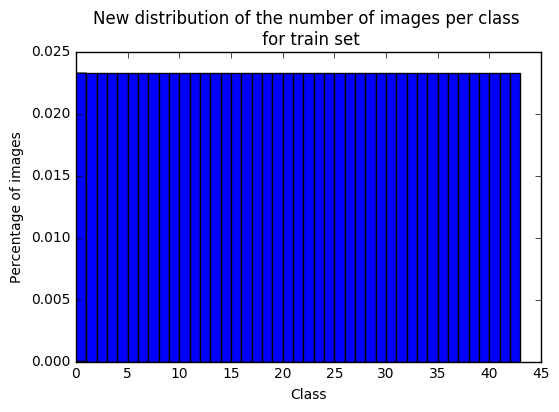

In [11]:
unique, counts = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

#print(dict(zip(unique, counts)))
plt.hist(y_train, color = 'b', label = 'train', normed = True, bins=range(n_classes+1))
plt.title('New distribution of the number of images per class \n for train set')
plt.xlabel('Class')
plt.ylabel('Percentage of images')
plt.show()


### 2. Validation Set & Randomization


In [12]:
VALIDATION_PERCENTAGE = .2

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train , y_valid = train_test_split(X_train, y_train, test_size=VALIDATION_PERCENTAGE)


In [13]:
print("Final number of training examples:", X_train.shape[0])
print("Final number of validation examples:", X_valid.shape[0])

Final number of training examples: 86000
Final number of validation examples: 21500


In [14]:
num_channels = 1
image_size = X_train.shape[1]

### 3. Convert to Gray Scale & Normalization

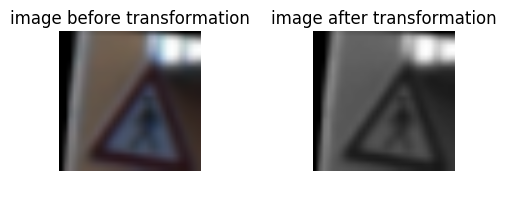

In [15]:
def convert_to_gray_scale(X, b = [0.299,0.587,0.114]):
    return np.inner(X, b)

def norm_image(image):
    image = convert_to_gray_scale(image).reshape(-1, image_size, image_size, 1)
    image = image/255 - 0.5
    return image

# pick a random index for the plotting example only
oi = np.random.randint(0,X_train.shape[0])

plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[oi])
plt.title('image before transformation')
plt.axis('off')

X_train = norm_image(X_train)
X_valid = norm_image(X_valid)
X_test_original = X_test
X_test = norm_image(X_test)

# plot same image in gray scale
plt.subplot(222)
plt.imshow(X_train[oi].reshape(32,32), cmap = 'gray')
plt.title('image after transformation')
plt.axis('off')
plt.show()


### 4. Reformat and one-hot encoding

In [16]:
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)

  labels = (np.arange(n_classes) == labels[:,None]).astype(np.float32)
  return dataset, labels

X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)

y_test_cls = np.argmax(y_test, axis=1)

print('Features set', X_train.shape, X_valid.shape, X_test.shape)
print('Labels set', y_train.shape, y_valid.shape, y_test.shape)

Features set (86000, 32, 32, 1) (21500, 32, 32, 1) (12630, 32, 32, 1)
Labels set (86000, 43) (21500, 43) (12630, 43)


### Question 1 

_Describe the techniques used to preprocess the data. Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Data preprocessing:
* Converted to gray scale
* Data normalization between -0.5 and 0.5 (see norm_image function)

I plotted a random example of data preprocessing above.

Note: Also tried to run it with all the RGB Channels but the accuracy was not as good.
That may be because gray scale reduces the number of parameters that the model has to play with. The accuracy perhaps comes more from the shape of the traffic sign rather than its color.


In [17]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


Done above in the following order: 
1. Data augmentation
2. Split train/valid/test
3. Gray scale, data normalization 

### Question 2

_Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

* I generated additional data by randomly rotating, translating and applying affine transformations to the images. (I re-used the transform_image function mentioned in the Udacity forum).<br>
The images from the cameras on the car will be taken in different conditions and from very close to very far away from the traffic signs. Therefore, it is important to give distorted images to train the model. This seems to also prevent the model from overfitting. <br>
Because the data set was very unbalanced, I decided to augment the data set so that all the classes have the same number of training examples. I chose a total (original + augmented images) of 2,500 training examples per class. (I plotted the original and final distribution above.) <br>
The reason for the change is that I noticed that the under-represented classes had worse accuracies than the over-represented ones. <br>
Previously, I had tried to generate additional data by preserving the distribution of classes (for example, triple the number of images in each class) but it did not improve the accuracy that much.

* After shuffling the training set, I randomly picked 20 percent of the training set for validation.

In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [19]:
# Get standard deviation of the normal distribution we use for weights initialization 
# of convolution and fully connected layers

def get_conv_bounds(input_feature_map, output_feature_map, filter_height, filter_width):
    fan_in = input_feature_map * filter_height * filter_width 
    fan_out = output_feature_map * filter_height * filter_width

    W_bound = np.sqrt(2. / (fan_in + fan_out))
    
    return W_bound

def get_fc_bounds(input_feature_map, output_feature_map):
    W_bound = np.sqrt(2. / (input_feature_map + output_feature_map))
    return W_bound


def create_conv_weight(input_feature_map, output_feature_map, filter_height, filter_width, weight_name):
    W_bound = get_conv_bounds(input_feature_map, output_feature_map, filter_height, filter_height)
    return tf.Variable(tf.truncated_normal(
            [filter_height, filter_width, input_feature_map, output_feature_map], stddev=W_bound), name=weight_name)


def create_fc_weight(input_feature_map, output_feature_map, weight_name):
    W_bound = get_fc_bounds(input_feature_map, output_feature_map)
    return tf.Variable(tf.truncated_normal(
        [input_feature_map, output_feature_map], stddev=W_bound), name=weight_name)

In [20]:
def conv2d(x, W, b, strides=1, is_relu=True):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x += b
    if is_relu:
        return tf.nn.relu(x)
    else:
        return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


In [21]:
def define_graph():
    
    tf_train_dataset = tf.placeholder(tf.float32, 
                          shape=[None, image_size, image_size, num_channels])
    tf_train_labels = tf.placeholder(tf.float32, 
                          shape=[None, n_classes])
    tf_train_labels_cls = tf.argmax(tf_train_labels, dimension=1)

    tf_beta = tf.placeholder(tf.float32)
    tf_keep_prob = tf.placeholder(tf.float32)
    tf_learning_rate = tf.placeholder(tf.float32)

    layer_width = {
        'layer_1': 48,
        'layer_2': 64,
        'layer_3': 128,
        'fc1': 512,
        'fc2': 512
    }

    weights = {
        'layer_1': create_conv_weight(input_feature_map = num_channels, output_feature_map = layer_width['layer_1']
                                      , filter_height = 3, filter_width = 3, weight_name = 'W_L1'),

        'layer_2': create_conv_weight(input_feature_map = layer_width['layer_1'], output_feature_map = layer_width['layer_2']
                                      , filter_height = 3, filter_width = 3, weight_name = 'W_L2'),

        'layer_3': create_conv_weight(input_feature_map = layer_width['layer_2'], output_feature_map = layer_width['layer_3']
                                      , filter_height = 3, filter_width = 3, weight_name = 'W_L3'),

        'fc1': create_fc_weight(input_feature_map = 2048, output_feature_map = layer_width['fc1']
                                    , weight_name = 'W_F1'),

        'fc2': create_fc_weight(input_feature_map = layer_width['fc1'], output_feature_map = layer_width['fc2']
                                    , weight_name = 'W_F2'),

        'out': create_fc_weight(input_feature_map = layer_width['fc2'], output_feature_map = n_classes
                                    , weight_name = 'W_out')
    }

    biases = {
        'layer_1': tf.Variable(tf.constant(0.0, shape=[layer_width['layer_1']]), name='b_L1'),
        'layer_2': tf.Variable(tf.constant(0.0, shape=[layer_width['layer_2']]), name='b_L2'),
        'layer_3': tf.Variable(tf.constant(0.0, shape=[layer_width['layer_3']]), name='b_L3'),
        'fc1': tf.Variable(tf.constant(0.0, shape=[layer_width['fc1']]), name='b_F1'),
        'fc2': tf.Variable(tf.constant(0.0, shape=[layer_width['fc2']]), name='b_F2'),
        'out': tf.Variable(tf.constant(0.0, shape=[n_classes]), name='b_out')
    }

    # Layer 1
    conv1 = conv2d(tf_train_dataset, weights['layer_1'], biases['layer_1'], is_relu = True)
    conv1 = maxpool2d(conv1)
    conv1_drop = tf.nn.dropout(conv1, tf_keep_prob)
    #print(conv1)

    # Layer 2
    conv2 = conv2d(conv1_drop, weights['layer_2'], biases['layer_2'], is_relu = True)
    conv2 = maxpool2d(conv2)
    conv2_drop = tf.nn.dropout(conv2, tf_keep_prob)
    #print('conv2')
    #print(conv2)

    # Layer 3
    conv3 = conv2d(conv2_drop, weights['layer_3'], biases['layer_3'], is_relu = True)
    conv3 = maxpool2d(conv3)
    conv3_drop = tf.nn.dropout(conv3, tf_keep_prob)
    #print('conv3')
    #print(conv3)

    # Flatten
    flat, num_fc_layers = flatten_layer(conv3_drop)

    # Fully connected layer
    fc1 = tf.add(tf.matmul(flat, weights['fc1']), biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, tf_keep_prob)
    #print(fc1)

    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, tf_keep_prob)
    #print(fc2)

    # Output Layer - class prediction
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'], name='logits')
    train_prediction = tf.nn.softmax(logits) 

    regularizers = (tf.nn.l2_loss(weights['layer_1']) 
                + tf.nn.l2_loss(weights['layer_2']) 
                + tf.nn.l2_loss(weights['layer_3']) 
                + tf.nn.l2_loss(weights['fc1'])
                + tf.nn.l2_loss(weights['fc2'])
                + tf.nn.l2_loss(weights['out']))

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                    labels=tf_train_labels)

    loss = tf.reduce_mean(cross_entropy) + tf_beta*regularizers 
    tf.summary.scalar('loss', loss) 

    with tf.name_scope('SGD'):
        optimizer = tf.train.AdamOptimizer(learning_rate=tf_learning_rate).minimize(loss) #AdamOptimizer #GradientDescentOptimizer

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):

          labels_pred_cls = tf.argmax(train_prediction,dimension = 1) 
          correct_prediction = tf.equal(labels_pred_cls, tf_train_labels_cls)

        with tf.name_scope('accuracy'):
          accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
          tf.summary.scalar('accuracy', accuracy_operation) 

    summary_op = tf.summary.merge_all()
    
    return tf_train_dataset, tf_train_labels, tf_train_labels_cls, tf_beta, tf_keep_prob, tf_learning_rate, weights, biases,conv1, conv2, conv3, flat, fc1, fc2, logits, train_prediction, regularizers,  cross_entropy, loss, optimizer, labels_pred_cls, correct_prediction, accuracy_operation, accuracy_operation, summary_op  
  

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Feed forward network architecture:

* Input: 
    * Shape: 32 x 32 x 1

* Convolution Layer: 
    * Input Feature Map = 1
    * Output Feature Map = 48
    * Filter: 3 x 3
    * Stride: 1
    * Padding: SAME 
* ReLU
* MaxPool
    * Stride: 2
    * Kernel size: 2 x 2
    * Padding: SAME
* Dropout
    * Keep probability: 0.5
    
* Convolution Layer: 
    * Input Feature Map = 48
    * Output Feature Map = 64
    * Filter: 3 x 3
    * Stride: 1
    * Padding: SAME 
* ReLU
* MaxPool
    * Stride: 2
    * Kernel size: 2 x 2
    * Padding: SAME
* Dropout
    * Keep probability: 0.5
    
* Convolution Layer: 
    * Input Feature Map = 64
    * Output Feature Map = 128
    * Filter: 3 x 3
    * Stride: 1
    * Padding: SAME 
* ReLU
* MaxPool
    * Stride: 2
    * Kernel size: 2 x 2
    * Padding: SAME
* Dropout
    * Keep probability: 0.5
    
* Flatten 
* Fully Connected Layer 1
    * Input Feature Map = 512
    * Output Feature Map = 512
* ReLU
* Dropout
    * Keep probability: 0.5
    
* Fully Connected Layer
    * Input Feature Map = 512
    * Output Feature Map = 512
* ReLU
* Dropout
    * Keep probability: 0.5
    
* Output layer
    * Input Feature Map = 512
    * Output Feature Map = 43 (number of classes)
    * Logits is the output of this last layer

* Softmax layer
    * Outputs probabilities



In [22]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [23]:
def evaluate(X_data, y_data, b, lr):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        summary, accuracy = sess.run([summary_op,accuracy_operation], feed_dict={tf_train_dataset : batch_x, tf_train_labels : batch_y, 
                         tf_beta: b, tf_keep_prob : 1, tf_learning_rate : lr})
        total_accuracy += (accuracy * len(batch_x))
    return summary, total_accuracy / num_examples


In [24]:
def train_model(beta, lr, name_ext, learn_decay):
    best_model_validation_acc = 0
    valid_acc_list = []
    train_acc_list = []
    
    save_file = './train_model_' + 'best' + '.ckpt'
    num_examples = X_train.shape[0]
    step = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as session:
        
        if(RELOAD_MODEL):
            # Load the weights and bias
            saver.restore(session, save_file)
        else:         
            session.run(tf.global_variables_initializer())
            
        print('tensorboard loc:', 'log-directory/' + str.replace(name_ext,'_','/') + '/train')
        train_writer = tf.summary.FileWriter('log-directory/' + str.replace(name_ext,'_','/') + '/train',session.graph)
        valid_writer =  tf.summary.FileWriter('log-directory/' + str.replace(name_ext,'_','/') + '/valid')

        for epoch in range(EPOCHS):

            if(learn_decay and epoch > 0 and epoch % 30 == 0 and lr > 1e-6):
                lr = lr/2
            
            # shuffling
            X_train_subset, y_train_subset = shuffle(X_train, y_train)

            # Train for all the mini-batches in the epoch
            for offset in range(0, num_examples, BATCH_SIZE):
                step += 1
                
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_subset[offset:end], y_train_subset[offset:end]

                feed_dict = {tf_train_dataset : batch_x, tf_train_labels : batch_y, 
                             tf_beta: BETA, tf_keep_prob : 0.5, tf_learning_rate : lr}

                session.run([optimizer], feed_dict = feed_dict)

            # at the end of the epoch, gather statistics
            training_summary, training_accuracy = evaluate(X_train, y_train, b = beta, lr = lr)
            train_writer.add_summary(training_summary, step)
            valid_summary, validation_accuracy = evaluate(X_valid, y_valid, b = beta, lr = lr)
            valid_writer.add_summary(valid_summary, step)
            print('Step %s / Epoch %s: Training accuracy: %s, Validation accuracy: %s' % (step, epoch, training_accuracy, validation_accuracy))
            valid_acc_list.append(validation_accuracy)
            train_acc_list.append(training_accuracy)

            if(epoch == 9 and validation_accuracy<0.9):
                print('break')
                break

            if(validation_accuracy > best_model_validation_acc):
                best_model_validation_acc = validation_accuracy
                
                saver.save(session, save_file) 
                print("Model saved at: ", save_file) 

        test_summary, test_accuracy = evaluate(X_test, y_test, b = beta, lr = lr)  
        print('Step %s / Epoch %s: Test accuracy: %s' % (step, epoch,test_accuracy))
        train_writer.close()   
        valid_writer.close()   
        
    return train_acc_list, valid_acc_list

In [25]:
def get_name_ext(timestr, beta, learning_rate, learn_decay, separator = '_'):
    return timestr + separator + str(beta) + separator + str(learning_rate) + separator + str(learn_decay)

def combine_acc_lists(beta, lr, ld, acc_list_temp, acc_list):
    length_acc_list_temp = len(acc_list_temp)
    beta_list = [beta] * length_acc_list_temp
    lr_list = [lr] * length_acc_list_temp
    ld_list = [ld] * length_acc_list_temp
    t = np.vstack((np.asarray(acc_list_temp),beta_list,lr_list,ld_list))
    
    if(acc_list is None):
        acc_list = t
    else:
        acc_list = np.concatenate((acc_list, t), axis = 1)
    
    return acc_list

In [26]:
combined_valid_acc_list = None
combined_train_acc_list = None

In [27]:
# This part was used for hyper-parameter search as well

EPOCHS = 2
BATCH_SIZE = 128
RELOAD_MODEL = False
HYPER_PARAM_SEARCH_ITERATIONS = 1 #5

timestr = time.strftime("%Y%m%d-%H%M%S"); print(timestr);

for i in range(HYPER_PARAM_SEARCH_ITERATIONS):

    #LEARNING_RATE = 10 ** np.random.uniform(low = -5, high = -2, size = 1)[0]
    #BETA = 10 ** np.random.uniform(low = -7, high = -3, size = 1)[0]
    
    LEARNING_RATE = 10 ** (-3) #10 ** np.random.uniform(low = -5, high = -3, size = 1)[0]
    BETA = 10**(-6) #10 ** np.random.uniform(low = -6, high = -3, size = 1)[0]
    
    for LEARN_DECAY in [True]: #False, True]
    
        # Remove the previous weights and bias
        tf.reset_default_graph()
        # Rebuild graph
        tf_train_dataset, tf_train_labels, tf_train_labels_cls, tf_beta, tf_keep_prob, tf_learning_rate, weights, biases,conv1, conv2, conv3, flat, fc1, fc2, logits, train_prediction, regularizers,  cross_entropy, loss, optimizer, labels_pred_cls, correct_prediction, accuracy_operation, accuracy_operation, summary_op  = define_graph()

        print('------------------------------------------------')
        print('beta:',BETA, ' / ', 'learning rate:', LEARNING_RATE, ' / ', 'learn decay:', LEARN_DECAY)
        print('------------------------------------------------')

        name_ext = get_name_ext(timestr=timestr, beta=BETA, learning_rate = LEARNING_RATE, learn_decay = LEARN_DECAY)

        train_acc_list_, valid_acc_list_ = train_model(beta = BETA
                                                       , lr = LEARNING_RATE
                                                       , name_ext = name_ext
                                                       , learn_decay = LEARN_DECAY)
                
        #combined_train_acc_list = combine_acc_lists(beta = BETA, lr = LEARNING_RATE, ld = LEARN_DECAY, acc_list_temp = train_acc_list_, acc_list = combined_train_acc_list)
        #combined_valid_acc_list = combine_acc_lists(beta = BETA, lr = LEARNING_RATE, ld = LEARN_DECAY, acc_list_temp = valid_acc_list_, acc_list = combined_valid_acc_list)
        
        #pickle.dump( combined_train_acc_list, open( "accuracies/train_acc_list.p", "wb" ) )
        #pickle.dump( combined_valid_acc_list, open( "accuracies/valid_acc_list.p", "wb" ) )
        #pickle.dump( combined_test_acc_list, open( "accuracies/test_acc_list.p", "wb" ) )

20161231-142309
------------------------------------------------
beta: 1e-06  /  learning rate: 0.001  /  learn decay: True
------------------------------------------------
tensorboard loc: log-directory/20161231-142309/1e-06/0.001/True/train


KeyboardInterrupt: 

In [28]:
save_file= './train_model_best1.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    
    _, test_accuracy = evaluate(X_test, y_test, b = BETA, lr = LEARNING_RATE)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.975


TODO: For the latest model, also show the train/valid accuracy and loss function

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- I used Adam optimizer with a batch size of 128. I read that we usually don't do hyper-parameter search on batch size but pick a value that works with our memory.
- I ran the final model for 80 epochs. The validation accuracy was not improving anymore.
- To determine the standard deviation of the normal distribution we use to initialize the weights, I used the formula 2/sqrt(fan_in+fan_out) for both convolutional layer and fully connected layers. (formula from http://cs231n.github.io/neural-networks-2/ and implemented in my function create_conv_weight and create_fc_weight)
- For the dropout layers, I chose a keep probability of 50%
- I performed random search for 2 hyper-parameters: learning rate and L2 regularization parameter. (see code below) <br>
I trained the model for 10 epochs using 10 random combinations of learning rate and L2 regularization (random layout was found to be more efficient than grid layout according to http://cs231n.github.io/neural-networks-3/) <br>
Log 10 of learning rate between -5 and -2 
Log 10 of L2 regularization parameter between  -7 and -3 <br><br>
L2 regularization parameter did not seem to impact the accuracy a lot. (see graphs below) Therefore, I fixed it to 10^-6. <br>
For the learning rate, 10^-3 is a good start and I applied a slow decay function (divide learning rate by 2 every 30 epochs). <br><br>

- For all the models I've tried I used Tensorboard to plot the accuracy and loss by epoch for the training and validation sets. 



### Hyper-parameter random search

#### Show the results of all models from 10 different ones

In [29]:
training_acc_file = 'accuracies/train_acc_list.p'
valid_acc_file = 'accuracies/valid_acc_list.p'
test_acc_file = 'accuracies/test_acc_list.p'

with open(training_acc_file, mode='rb') as f:
    combined_train_acc_list = pickle.load(f)
with open(valid_acc_file, mode='rb') as f:
    combined_valid_acc_list = pickle.load(f)
with open(test_acc_file, mode='rb') as f:
    combined_test_acc_list = pickle.load(f)
    

In [50]:
all_acc = np.row_stack([combined_train_acc_list, combined_valid_acc_list[0], combined_test_acc_list[0]])
print(all_acc.shape)

(6, 1)


In [51]:
def prepare_analysis(df):
    
    acc_2 = pd.DataFrame(np.transpose(df))

    acc_2.columns = ['Acc_train','Beta', 'Learning_Rate', 'Learning_Decay', 'Acc_valid', 'Acc_test']
    acc_2['Group'] = acc_2['Beta'] + acc_2['Learning_Rate'] + acc_2['Learning_Decay']
    
    return acc_2

acc = prepare_analysis(all_acc)
acc['counter'] = acc.groupby(['Beta','Learning_Rate','Learning_Decay']).cumcount()+1
acc = acc.sort_values(['Beta', 'Learning_Rate', 'Learning_Decay', 'counter'])


In [52]:
# Find the best accuracy for the parameters:
idx = acc.groupby(['Group'])['Acc_valid'].transform(max) == acc['Acc_valid']
best_acc = acc[idx]
best_acc

Acc_train     Beta  Learning_Rate  Learning_Decay  Acc_valid  Acc_test  \
0   0.109375  0.00001          0.001             1.0     0.0625  0.078125   

     Group  counter  
0  1.00101        1

/Users/morganelustman/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-5.0, right=-5.0
  'left=%s, right=%s') % (left, right))
/Users/morganelustman/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0625, top=0.0625
  'bottom=%s, top=%s') % (bottom, top))
/Users/morganelustman/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-3.0, right=-3.0
  'left=%s, right=%s') % (left, right))


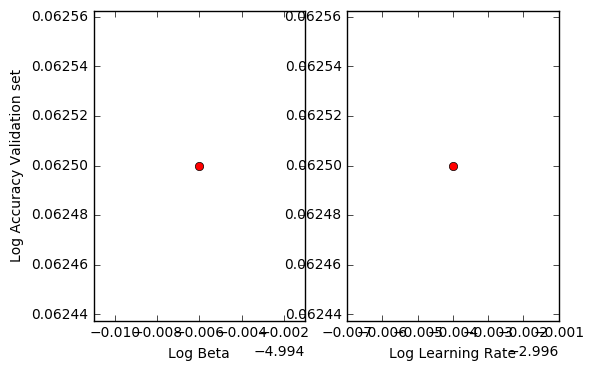

In [53]:
min_acc = best_acc['Acc_valid'].min()
max_acc = best_acc['Acc_valid'].max()

# Plot best accuracy v.s. beta
min_beta = np.log10(best_acc['Beta']).min() 
max_beta = np.log10(best_acc['Beta']).max() 

fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.log10(best_acc["Beta"]), best_acc["Acc_valid"], 'ro')
#axes = plt.gca()
ax1.set_xlim( [min_beta,max_beta])
ax1.set_ylim([min_acc, max_acc])
ax1.set_xlabel('Log Beta')

# Plot best accuracy v.s. learning_rate
min_lr = np.log10(best_acc['Learning_Rate']).min() 
max_lr = np.log10(best_acc['Learning_Rate']).max() 

#ig, ax = plt.subplots(1,1); 
ax2.plot(np.log10(best_acc["Learning_Rate"]), best_acc["Acc_valid"], 'ro')
ax2.set_xlim( [min_lr,max_lr])
ax2.set_ylim([min_acc, max_acc])
ax2.set_xlabel('Log Learning Rate')

ax1.set_ylabel('Log Accuracy Validation set')

plt.show()

/home/carnd/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/carnd/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


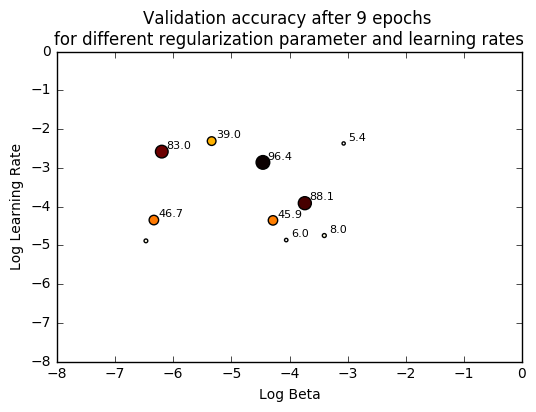

In [38]:
best_acc_matrix = best_acc[["Beta","Learning_Rate","Acc_valid"]]

best_acc_matrix["log_beta"] = np.log10(best_acc_matrix["Beta"])
best_acc_matrix["log_learning_rate"] = np.log10(best_acc["Learning_Rate"])

cm = plt.cm.get_cmap('hot')
plt.scatter(x=np.log10(best_acc["Beta"]), y=np.log10(best_acc["Learning_Rate"]), 
            c=-best_acc["Acc_valid"],s=100*best_acc["Acc_valid"],
            cmap=cm)
plt.xlim( [-8,0])
plt.ylim( [-8,0])
plt.xlabel('Log Beta')
plt.ylabel('Log Learning Rate')

#best_acc_matrix.get_value(240,"Acc_test")

row_iterator = best_acc_matrix.iterrows()
_, last = next(row_iterator)  
for i, row in row_iterator:
    plt.annotate(round(100*row["Acc_valid"],1), (row["log_beta"]+0.08,row["log_learning_rate"]+0.08),
                fontsize=8)

plt.title("Validation accuracy after 9 epochs \nfor different regularization parameter and learning rates")
plt.show()


In [46]:
!tensorboard --logdir=log-directory/20161230-163637

I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcublas.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcudnn.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcufft.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcurand.so locally
Starting TensorBoard b'39' on port 6006
(You can navigate to http://172.31.6.249:6006)
^CTraceback (most recent call last):
  File "/home/carnd/anaconda3/envs/CarND-LeNet-Lab/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/home/carnd/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/home/carnd/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/socketserver.py", line 23

### Look at the weights of the first layer

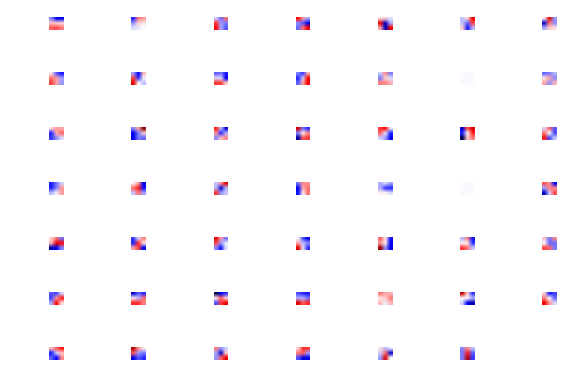

In [33]:
save_file= './train_model_best1.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    weights_layer_1 = session.run(weights['layer_1'])

    # min/max values of weights
    wmin = np.min(weights_layer_1)
    wmax = np.max(weights_layer_1)

    fig, axes = plt.subplots(7,7)

    for i, ax in enumerate(axes.flat):
        if i < 48:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = weights_layer_1[:,:,0,i].reshape([3,3]) #w[:, i].reshape(image_shape)

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
            ax.axis('off')

    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

### Plot some examples where the model is wrong

In [33]:
save_file= './train_model_best1.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)

    num_examples = len(X_test)

    ct = None
    labels_predicted = None
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_test[offset:offset+BATCH_SIZE], y_test[offset:offset+BATCH_SIZE]
        c,labels_predicted_temp = session.run([correct_prediction,labels_pred_cls], feed_dict={tf_train_dataset : batch_x, tf_train_labels : batch_y, 
                         tf_beta: BETA, tf_keep_prob : 1, tf_learning_rate : LEARNING_RATE})

        if ct is None:
            ct = c
            labels_predicted = labels_predicted_temp
        else:
            ct = np.concatenate((ct,c),axis = 0)
            labels_predicted = np.concatenate((labels_predicted,labels_predicted_temp),axis = 0)

    pred_error = (ct == False)
    X_error_original = X_test_original[pred_error]
    X_error = X_test[pred_error]
    y_error_true = y_test_cls[pred_error]
    y_error_pred = labels_predicted[pred_error]


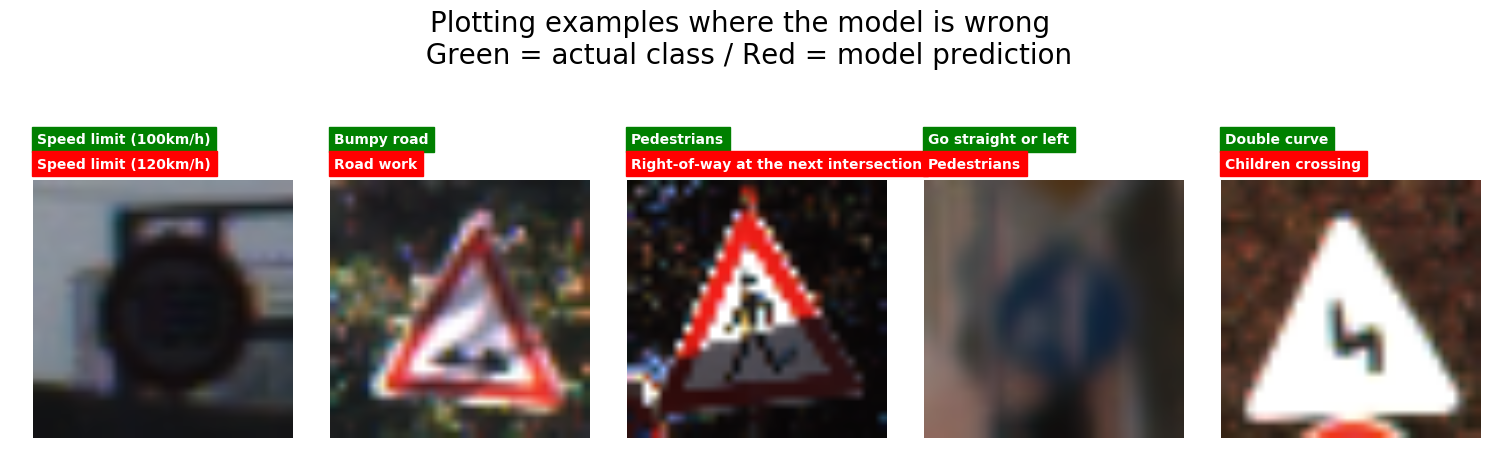

In [65]:
fig = plt.figure(figsize=(15, 15))

for i in range(5):
    oi = np.random.randint(0,y_error_pred.shape[0])
    fig.add_subplot(1,5,i+1)
    plt.imshow(X_error_original[oi])
    #plt.imshow(X_error[oi].reshape(32,32), cmap = 'gray')
    plt.text(0,-5,signnames[str(y_error_true[oi])],color='w',backgroundcolor='g', fontsize=10, weight="bold") 
    plt.text(0,-2,signnames[str(y_error_pred[oi])],color='w',backgroundcolor='r', fontsize=10, weight="bold") 
    plt.axis('off')

fig.suptitle('Plotting examples where the model is wrong \n Green = actual class / Red = model prediction', x=0.5,y=0.7, fontsize=20)
plt.tight_layout()
plt.show() 

Some of the traffic signs where the model is mistaken are hard to classify for me as well.
Images taken at night with poor lightning are harder to classify.
Sometimes the model recognizes that it is a speed limit sign but gets the wrong number.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with a LeNet architecture as discussed in the class, adding dropout and L2 regularization but no data augmentation.
For some reason, even my training accuracy was very low. The model was not learning at all.

I changed the standard deviation of the normal distribution used for the weights initialization (using the formula 2/sqrt(fan_in+fan_out) from http://cs231n.github.io/neural-networks-2/) and the training accuracy went up. 

I then set up my code to perform hyper-parameter search and with a better learning rate, both training accuracy and validation accuracy improved.

To improve the validation accuracy, I've tried many different things at the same time (this was probably a bad idea since it took me a long time to figure out what was working vs not working):
- Change the size of the filters between 3x3 and 5x5
- Change the number of feature maps of each layer
- Do something similar to inception module where I'd concatenate the flattened output of all the convolution layers to pass to the fully connected layer. This approach was overfitting too much so I got rid of it. (better training accuracy than validation accuracy).
- Use learning rate decay
- Augment data: at first by keeping the distribution of examples between classes the same, and then by making the distribution uniform. The reason for the change is that I noticed that the under-represented classes had worse accuracies than the over-represented ones.

At the same time, I set up tensorboard to debug my models: For instance, by visualizing the biases, I realized that they were all zeros because I had forgotten to initialize them. I was also looking at the distribution of the activations of all the ReLU layers to make sure that they were not all going to zero. When I switched from training the model locally to training it on the AWS instance, I had to get rid of most of my Tensorbard code because the instance was running out of memory. 
I then decided to plot the weights of the first convolution in the notebook instead (see below). I wanted to make sure that they had a nice shape, which means that the model converged well.

Finally, I decided that I'd stick to the architecture that had given me the best validation accuracy so far. I did hyper-parameter search again. After finding the best parameters, I trained the model for 80 epochs. (so far, I was only running the model for 10 epochs to save time, but running it for 80 epochs improved the training/validation accuracy more than I expected). And in the end, my validation accuracy was 99.9% and test accuracy 97.5%

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [54]:
os.listdir("french_traffic-signs/")
repo = "french_traffic-signs/"
X = []
for image_locations in os.listdir(repo):
    if image_locations != '.DS_Store':
        img = mpimg.imread(repo+image_locations)
        img_resized = cv2.resize(img,(image_size,image_size), interpolation = cv2.INTER_AREA)
        X.append(img_resized)
    
X2 = np.stack(X, axis = 0)
X2 = X2.astype(np.uint8)

num_own_examples = len(X2)


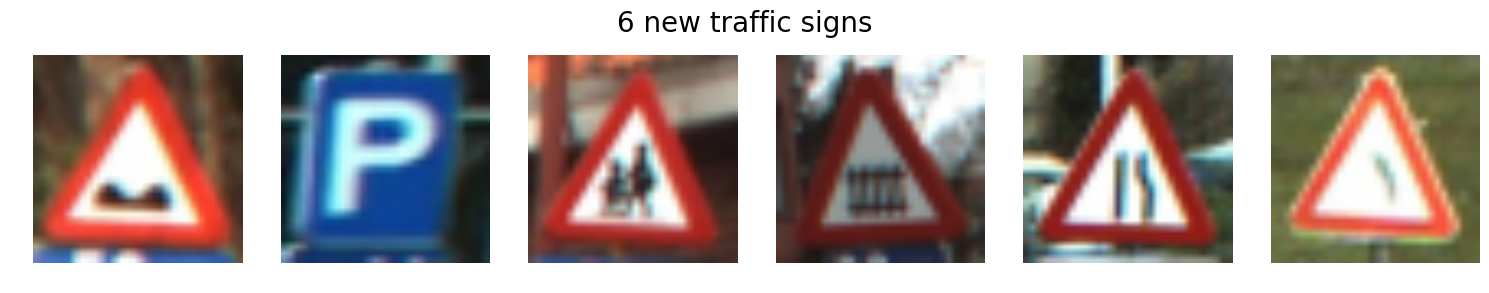

In [70]:
fig = plt.figure(figsize=(15, 15))
gr = gridspec.GridSpec(1, 6)
for i in range(num_own_examples):
    plt.subplot(1,6,i+1)
    plt.imshow(X2[i])
    plt.axis('off')
plt.tight_layout()
fig.suptitle('6 new traffic signs', x=0.5,y=0.6, fontsize=20)
plt.show()  

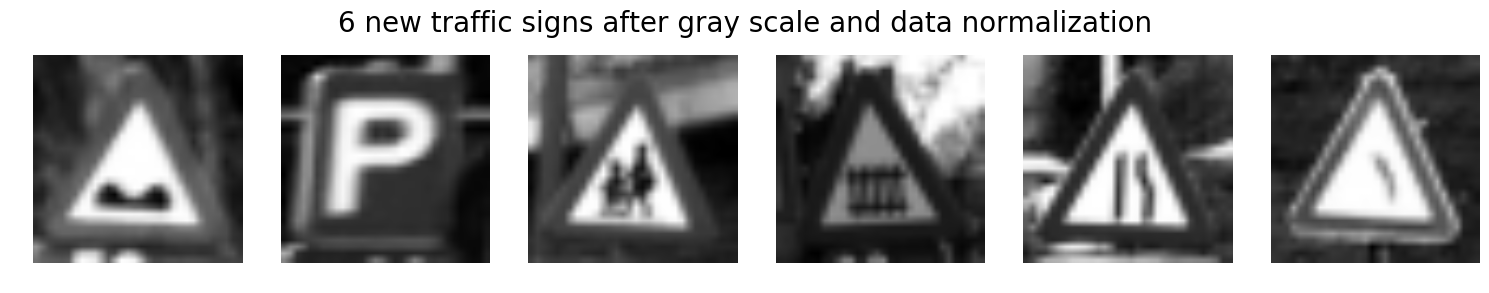

In [73]:
# Prepare for model:
X2_norm = norm_image(X2)

fig = plt.figure(figsize=(15, 15))
gr = gridspec.GridSpec(1, 6)
for i in range(num_own_examples):
    plt.subplot(1,6,i+1)
    plt.imshow(X2_norm[i].reshape(32,32), cmap = 'gray')
    plt.axis('off')
plt.tight_layout()
fig.suptitle('6 new traffic signs after gray scale and data normalization', x=0.5,y=0.6, fontsize=20)
plt.show()  

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I've plotted the 6 images above.
- 2 signs ("parking" and "train crossing") are not part of the original dataset so the model won't be able to classify them properly. It will be insteresting to see what it comes up with. 
- 2 signs ("children crossing" and "dangerous turning to the left") exist in both German and Belgium traffic signs but are different.
- 2 signs ("bumpy road" and "road narrows on the right") are similar in Germany and Belgium.

In [86]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [87]:
save_file= './train_model_best1.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    feed_dict = {tf_train_dataset : X2_norm, tf_keep_prob : 1}
    proba = session.run(train_prediction, feed_dict)

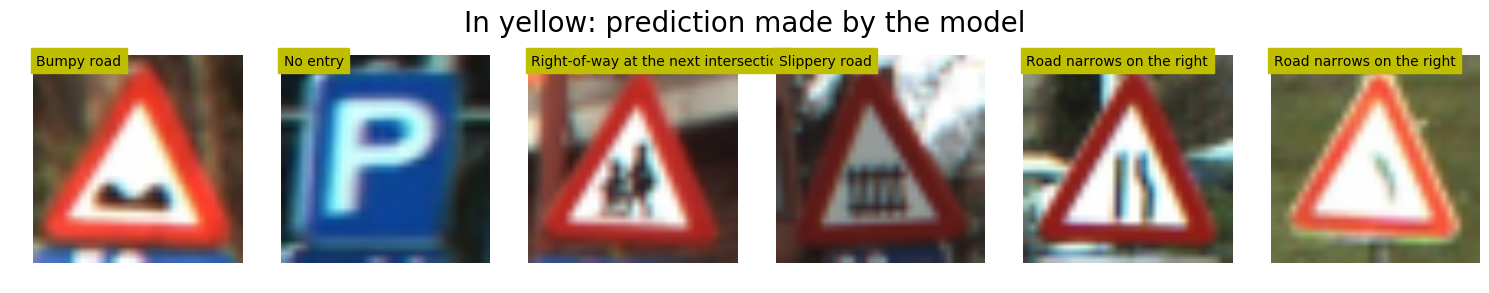

In [88]:
fig = plt.figure(figsize=(15, 15))

gr = gridspec.GridSpec(1, 6)
for i in range(num_own_examples):
    probas = proba[i]
    highest_class = signnames[str(np.argmax(probas, axis =0))]
    plt.subplot(1,6,i+1)
    plt.imshow(X2[i])
    plt.axis('off')
    plt.text(0,1,highest_class,color='k',backgroundcolor='y')
fig.suptitle('In yellow: prediction made by the model', x=0.5,y=0.6, fontsize=20)
plt.tight_layout()
plt.show()    
 

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate.

NOTE: You could check the accuracy manually by using signnames.csv (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in signnames.csv and see if it matches the sign from the image._


**Answer:**

The 2 signs that are similar in Germany and Belgium were predicted correctly by the model (100% accuracy on these 2 signs).

However, for the 4 other signs, the model is wrong. So, the overall accuracy is 33%. 

A few reasons come into mind: <br>
- 2 signs (parking and train crossing) are not part of the original dataset so the model could not have classified them properly. 
- 2 signs exist in both German and Belgium traffic signs but are different. For example, "children crossing" and "dangerous turning to the left"


In [43]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [84]:
save_file= './train_model_best1.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    feed_dict = {tf_train_dataset : X2_norm, tf_keep_prob : 1}
    proba = session.run(train_prediction, feed_dict)

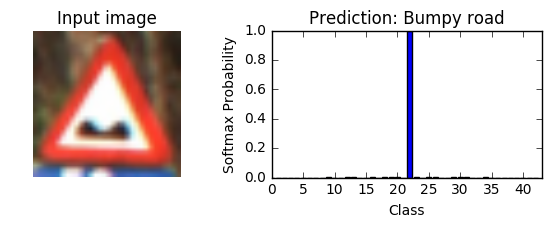

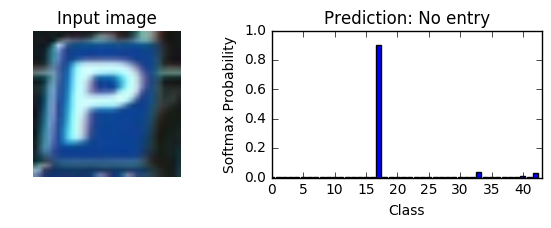

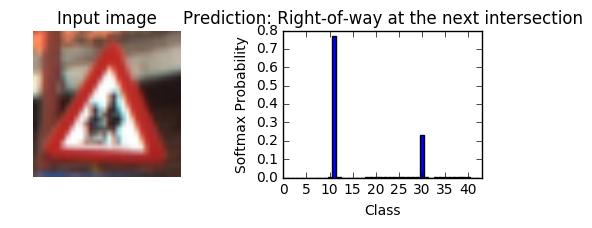

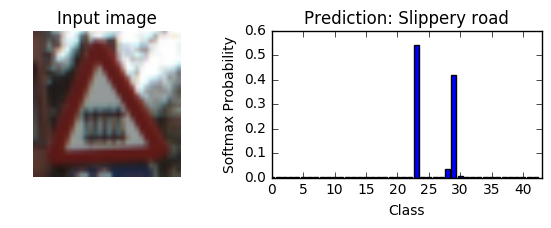

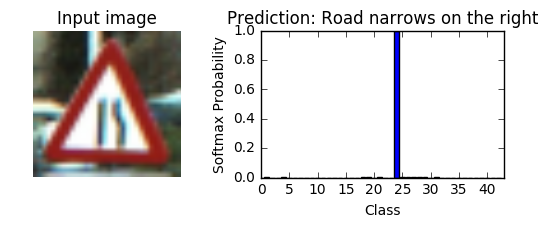

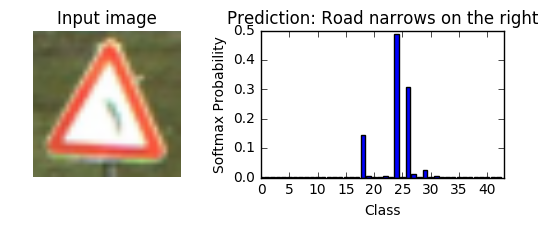

In [85]:
for i in range(num_own_examples):
    
    probas = proba[i]
    
    highest_class = signnames[str(np.argmax(probas, axis =0))]
    
    plt.figure(1)

    plt.subplot(221)
    plt.imshow(X2[i])
    plt.title('Input image')
    plt.axis('off')
    
    plt.subplot(222)
    y_pos = np.arange(n_classes)
        
    plt.bar(y_pos,probas, align='center')
    plt.xlabel('Class')
    plt.ylabel('Softmax Probability')
    plt.title('Prediction: '+highest_class)
    plt.xlim([0,n_classes])
    
    plt.tight_layout()
    plt.show()

In [80]:
save_file= './train_model_best1.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, save_file)
    feed_dict = {tf_train_dataset : X2_norm, tf_keep_prob : 1}
    logi = session.run(logits, feed_dict)
    predicts = session.run(tf.nn.top_k(logi, k=5, sorted=True))
    proba = session.run(tf.nn.softmax(predicts[0]))

Selecting only the top 5 predictions and rerunning softmax


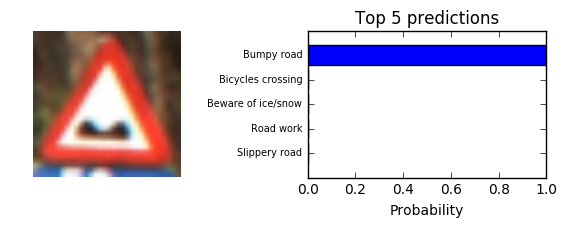

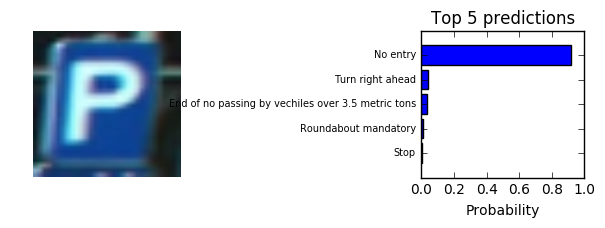

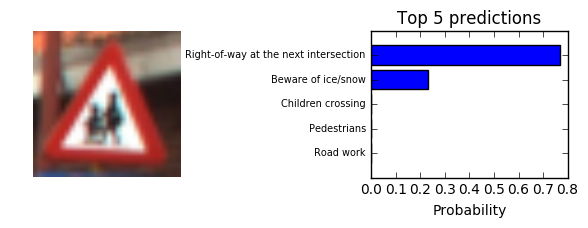

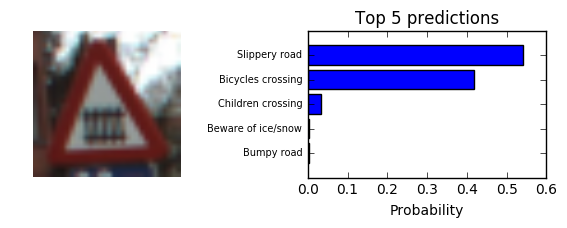

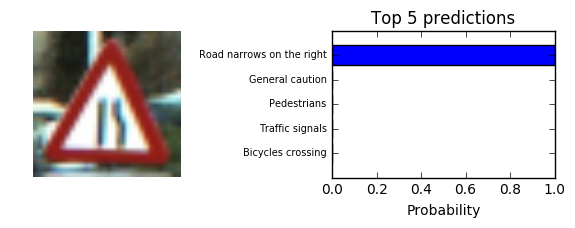

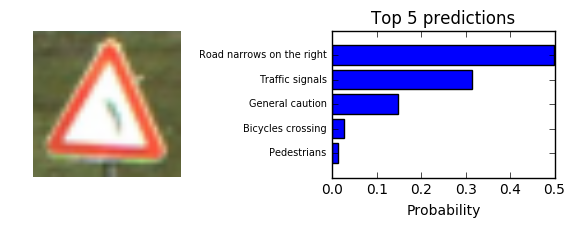

In [82]:
print('Selecting only the top 5 predictions and rerunning softmax')
num_own_examples = len(X2_norm)
for i in range(num_own_examples):
    
    probas = proba[i]
    names = np.asarray([signnames[str(p)] for p in predicts[1][i]])
    
    plt.figure(1)

    plt.subplot(221)
    plt.imshow(X2[i])
    plt.axis('off')
    
    plt.subplot(222)
    y_pos = np.arange(len(names))[::-1]
    plt.barh(y_pos,probas, align='center')
    plt.yticks(y_pos, names, fontsize=7)
    plt.xlabel('Probability')
    plt.title('Top 5 predictions')
    
    
    plt.tight_layout()
    plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model is extremely certain for the signs that are the same in Germany and Belgium ("Bumpy road" and "road narrows on the right") and it got them right.

The model was more uncertain for the signs that it got wrong:

- For the "parking" sign, which does not exist in the original datset, the strongest prediction was "no entry". It may come from the strong white band in the middle of the sign. If the original dataset had a sign with a squared shape, the model may have predicted it.
<br>
- For the "train crossing" sign, which does not exist in the original datset, the strongest predictions are all signs of red triangular shape with something black in the middle. The model is quite uncertain about its prediction since there are several options and none of them is perfect.
<br>
- For the "children crossing" sign, which exists in Germany but is slightly different from the Belgium sign, all the predictions are from the same kind of signs (red triangular shape with something black in the middle) and the correct prediction is ranked 3rd
<br>
- For the "dangerous turning to the left", which exists in Germany but is slightly different from the Belgium sign, all the predictions are from the same kind of signs (red triangular shape with something black in the middle) but the correct prediction does not appear in the top 5.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.